In [1]:
#!pip install scikit-learn

In [5]:
#import the require packages
import flopy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mf6Voronoi.utils import initiateOutputFolder
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score, mean_squared_error

In [6]:
#define model name and model path
simName = 'mf6Sim'
modelName = 'mf6Model'
modelWs = 'modelFiles'

In [7]:
#open the observation file out heads
obsOut = flopy.utils.observationfile.Mf6Obs(modelWs+'/'+modelName+'.ob_gw_out_head',isBinary=False)

In [8]:
#create a dataframe for the observation points
totalObsDf = obsOut.get_dataframe().transpose()
totalObsDf = totalObsDf.rename(columns={totalObsDf.keys()[0]:'SimHead'})
totalObsDf = totalObsDf.drop('totim',axis=0)
totalObsDf['ObsHead'] = 0
totalObsDf['Easting'] = 0
totalObsDf['Northing'] = 0
totalObsDf.head()

,SimHead,ObsHead,Easting,Northing
OBS-1,3651.465760,0,0,0
OBS-2,3409.044730,0,0,0
OBS-3,4334.659461,0,0,0
OBS-4,4002.605215,0,0,0
OBS-5,4288.889346,0,0,0


In [15]:
#open the observed data file
obsDf = gpd.read_file('shp/piezometers.shp')
obsDf.head()

,asterDem18,depth,sampleElev,Name,waterHead,geometry
0,3654.0,50.0,3604.0,Obs-1,3651.46,POINT (624499.129 8352633.976)
1,3408.0,80.0,3328.0,Obs-2,3409.04,POINT (624449.604 8350479.537)
2,4418.0,120.0,4298.0,Obs-3,4334.65,POINT (627861.729 8362737.518)
3,3992.0,50.0,3942.0,Obs-4,4002.60,POINT (622454.282 8363377.918)
4,4426.0,30.0,4396.0,Obs-5,4288.88,POINT (630121.236 8359513.618)


In [19]:
#look for the observed elevation and coordinates
for index, row in totalObsDf.iterrows():
    for index2, row2 in obsDf.iterrows():
        if index.lower() == row2.Name.lower():
            totalObsDf.loc[index,'ObsHead'] = row2.waterHead
            totalObsDf.loc[index,'Easting'] = float(row2.geometry.x)
            totalObsDf.loc[index,'Northing'] = float(row2.geometry.y)

In [20]:
#compute the residual and save csv file
#initiateOutputFolder('../Model/output')

totalObsDf = totalObsDf[totalObsDf['SimHead']>0]
totalObsDf['Residual'] = totalObsDf['SimHead'] - totalObsDf['ObsHead']
totalObsDf.to_csv('output/HobDf_Out.csv')
totalObsDf.head()

,SimHead,ObsHead,Easting,Northing,Residual
OBS-1,3651.465760,3651.46,624499.128685,8.352634e+06,0.005760
OBS-2,3409.044730,3409.04,624449.604011,8.350480e+06,0.004730
OBS-3,4334.659461,4334.65,627861.729032,8.362738e+06,0.009461
OBS-4,4002.605215,4002.60,622454.281712,8.363378e+06,0.005215
OBS-5,4288.889346,4288.88,630121.236036,8.359514e+06,0.009346


In [22]:
filterObsDf=totalObsDf.dropna()
filterObsDf

,SimHead,ObsHead,Easting,Northing,Residual
OBS-1,3651.465760,3651.46,624499.128685,8.352634e+06,0.005760
OBS-2,3409.044730,3409.04,624449.604011,8.350480e+06,0.004730
OBS-3,4334.659461,4334.65,627861.729032,8.362738e+06,0.009461
OBS-4,4002.605215,4002.60,622454.281712,8.363378e+06,0.005215
OBS-5,4288.889346,4288.88,630121.236036,8.359514e+06,0.009346
OBS-6,4466.874147,4466.87,629647.239500,8.372185e+06,0.004147
OBS-7,4305.079821,4305.07,626337.304622,8.366766e+06,0.009821
OBS-8,4052.336978,4052.33,618201.999654,8.363231e+06,0.006978
OBS-9,3939.246502,3939.24,616508.316824,8.356195e+06,0.006502
OBS-10,4224.530593,4224.53,627020.708097,8.359024e+06,0.000593


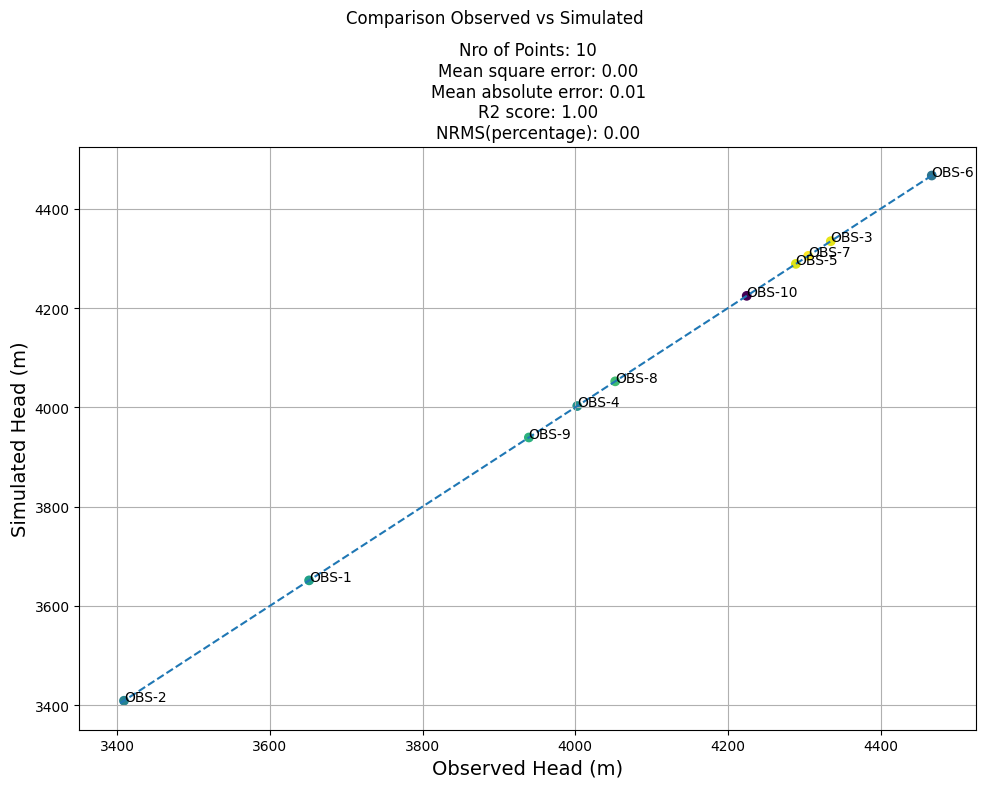

In [24]:
#Create a basic scatter plot with Matplotlib
#A identity line was created based on the minumum and maximum observed value
#Points markers are colored by the residual and a residual colorbar is added to the figure
fig = plt.figure(figsize=(10,8))

minMin = np.min([filterObsDf['SimHead'].min(),filterObsDf['ObsHead'].min()])
maxMax = np.max([filterObsDf['SimHead'].max(),filterObsDf['ObsHead'].max()])
meanSquareError = mean_squared_error(filterObsDf['ObsHead'],filterObsDf['SimHead'])
meanAbsoluteError = mean_absolute_error(filterObsDf['ObsHead'],filterObsDf['SimHead'])
r2score = r2_score(filterObsDf['ObsHead'],filterObsDf['SimHead'])
nrms = (meanSquareError**0.5)/(maxMax-minMin)*100

x = np.linspace(filterObsDf['SimHead'].min()-5, filterObsDf['SimHead'].max()+5, 100)
plt.plot(x, x, linestyle='dashed')
plt.scatter(filterObsDf['ObsHead'],filterObsDf['SimHead'], marker='o', c=filterObsDf['Residual'])
for index, row in filterObsDf.iterrows():
    if row['ObsHead'] > 0:
        plt.text(int(row['ObsHead']),int(row['SimHead']),index)

#cbar = plt.colorbar()
#cbar.set_label('Residual (m)', fontsize=14)

plt.grid()
plt.suptitle('Comparison Observed vs Simulated')
plt.title('''Nro of Points: %d
    Mean square error: %.2f
    Mean absolute error: %.2f
    R2 score: %.2f
    NRMS(percentage): %.2f'''%(filterObsDf.shape[0],meanSquareError,meanAbsoluteError,r2score,nrms))
plt.xlabel('Observed Head (m)', fontsize=14)
plt.ylabel('Simulated Head (m)', fontsize=14)
fig.tight_layout()